## 1. Data Preparation

In [6]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# load json cluster labels
with open('data/result/countries_per_cluster.json', 'r', encoding='utf-8') as f:
    cluster_json = json.load(f)

# create Country -> Cluster Mapping 
country_to_cluster = {}
for item in cluster_json:
    c_id = item['cluster_kmeans']
    for country in item['countries']:
        country_to_cluster[country] = c_id

# load main dataset
df_raw = pd.read_csv('data/processed/country_index_matrix_HIGH_VARIANCE.csv')

# add cluster labels to dataset (Target Y)
df_raw['Cluster'] = df_raw['Country'].map(country_to_cluster)

# clean unlabeled rows if any 
df_clean = df_raw.dropna(subset=['Cluster'])
df_clean['Cluster'] = df_clean['Cluster'].astype(int)

# fix date format (Temporal Split için)
df_clean['date'] = pd.to_datetime(df_clean['date'])

#median Imputation
features = [col for col in df_clean.columns if col not in ['date', 'Country', 'Cluster', 'iso_code']]
df_clean[features] = df_clean[features].fillna(df_clean[features].median())

print(f"Data: {df_clean.shape[0]} rows, {len(features)} features")
print(f"date interval: {df_clean['date'].min().date()} - {df_clean['date'].max().date()}")

Data: 11060 rows, 24 features
date interval: 2021-12-26 - 2024-12-29


## 2. Defining Models and Grid Search Parameters

In [7]:
# models and their parameter inputs
models_config = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [5, 10, 20, None],
            "criterion": ["gini", "entropy"]
        }
    },
    "SVM": {
        "model": SVC(random_state=42),
        "params": {
            "C": [1, 10],
            "kernel": ["linear", "rbf"] 
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [10, 20, None],
            "criterion": ["gini", "entropy"]
        }
    }
}

## 3. Training and Validation

In [8]:
def run_experiment(split_type, df, feature_cols):
    results = []
    
    # SPLIT STRATEGY
    if split_type == "Temporal":
        # sort by date 
        df_sorted = df.sort_values('date').reset_index(drop=True)
        
        # find %80 of the weeks
        split_index = int(len(df_sorted) * 0.80)
        split_date = df_sorted.iloc[split_index]['date']
        
        print(f" Temporal Cutoff Date: {split_date.date()}")
        
        # first %80 = Train, last %20 = Test
        # it's safer to split by date instead of using an index (so that countries in the same week aren't split).
        train_mask = df['date'] < split_date
        test_mask = df['date'] >= split_date
        
    elif split_type == "Spatial":
        # Train: 56 Countries (80%) , Test: 14 Countries (20%)
        all_countries = df['Country'].unique()
        n_test = int(len(all_countries) * 0.20) # compute %20 (14 countries)
        
        np.random.seed(42)
        test_countries = np.random.choice(all_countries, size=n_test, replace=False)
        
        train_mask = ~df['Country'].isin(test_countries)
        test_mask = df['Country'].isin(test_countries)
        print(f" Spatial Test Countries ({len(test_countries)}): {test_countries}")

    # Split Data
    X_train = df.loc[train_mask, feature_cols]
    y_train = df.loc[train_mask, 'Cluster']
    X_test = df.loc[test_mask, feature_cols]
    y_test = df.loc[test_mask, 'Cluster']
    
    # Sanity Check
    total_samples = len(df)
    test_ratio = len(X_test) / total_samples
    print(f" Train Size: {len(X_train)} , Test Size: {len(X_test)} (Ratio: %{test_ratio*100:.1f})")

    # SCALING (RobustScaler)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # MODEL TRAINING LOOP 
    best_rf_model = None
    
    for name, config in models_config.items():        
        grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1_macro', n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        
        y_pred = grid.predict(X_test_scaled)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        results.append({
            "Split Type": split_type,
            "Model": name,
            "Accuracy": acc,
            "F1-Macro": f1,
            "Best Params": grid.best_params_
        })
        
        if name == "Random Forest":
            best_rf_model = grid.best_estimator_

    return pd.DataFrame(results), best_rf_model, X_test, y_test, X_train.columns

## 4. Run experiments

In [9]:
# EXPERIMENT 1: TEMPORAL SPLIT
res_temporal, rf_model_temp, X_test_temp, y_test_temp, feature_names = run_experiment("Temporal", df_clean, features)

# EXPERIMENT 2: SPATIAL SPLIT 
res_spatial, _, _, _, _ = run_experiment("Spatial", df_clean, features)

#
final_results = pd.concat([res_temporal, res_spatial], ignore_index=True)
print("\n FINAL EXPERIMENTAL RESULTS (Phase 2):")
print(final_results[['Split Type', 'Model', 'Accuracy', 'F1-Macro']].to_markdown(index=False))


 Temporal Cutoff Date: 2024-05-26
 Train Size: 8820 , Test Size: 2240 (Ratio: %20.3)
 Spatial Test Countries (14): ['IE' 'US' 'NG' 'TR' 'SK' 'SE' 'IT' 'AE' 'CO' 'AU' 'VN' 'RU' 'LV' 'BR']
 Train Size: 8848 , Test Size: 2212 (Ratio: %20.0)

 FINAL EXPERIMENTAL RESULTS (Phase 2):
| Split Type   | Model               |   Accuracy |   F1-Macro |
|:-------------|:--------------------|-----------:|-----------:|
| Temporal     | Logistic Regression |   0.874107 |   0.88094  |
| Temporal     | Decision Tree       |   0.798214 |   0.804527 |
| Temporal     | SVM                 |   0.908036 |   0.90067  |
| Temporal     | Random Forest       |   0.972321 |   0.974863 |
| Spatial      | Logistic Regression |   0.699819 |   0.542717 |
| Spatial      | Decision Tree       |   0.520796 |   0.394805 |
| Spatial      | SVM                 |   0.686257 |   0.492038 |
| Spatial      | Random Forest       |   0.686257 |   0.557783 |


## 5. Visualization

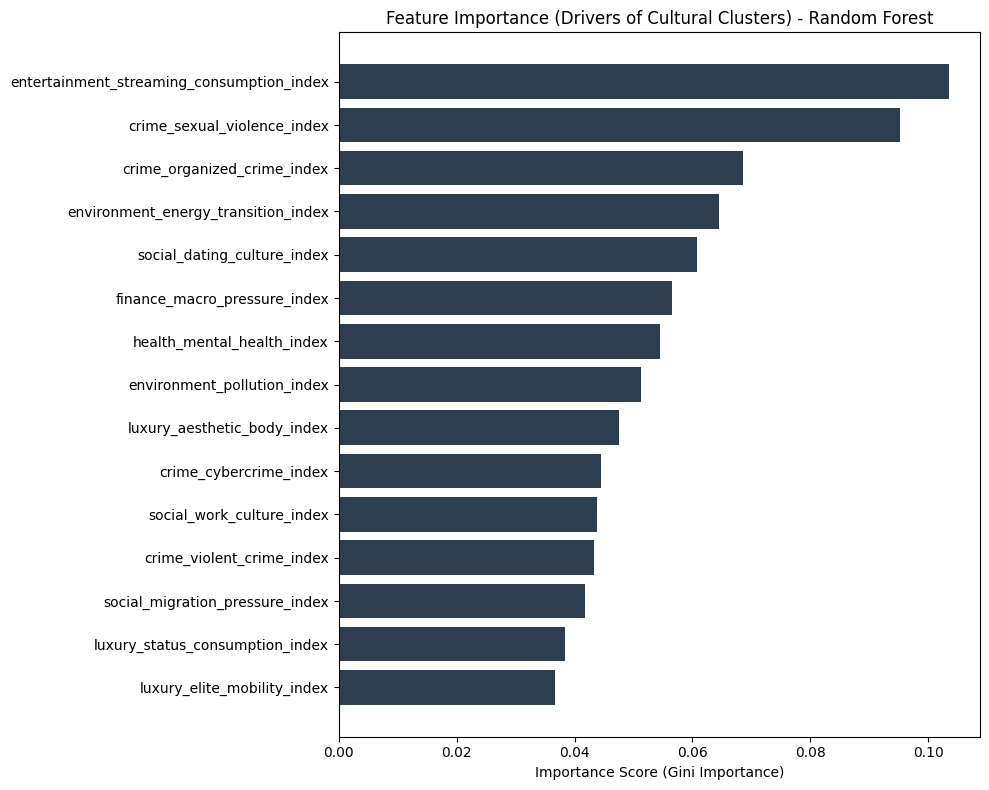

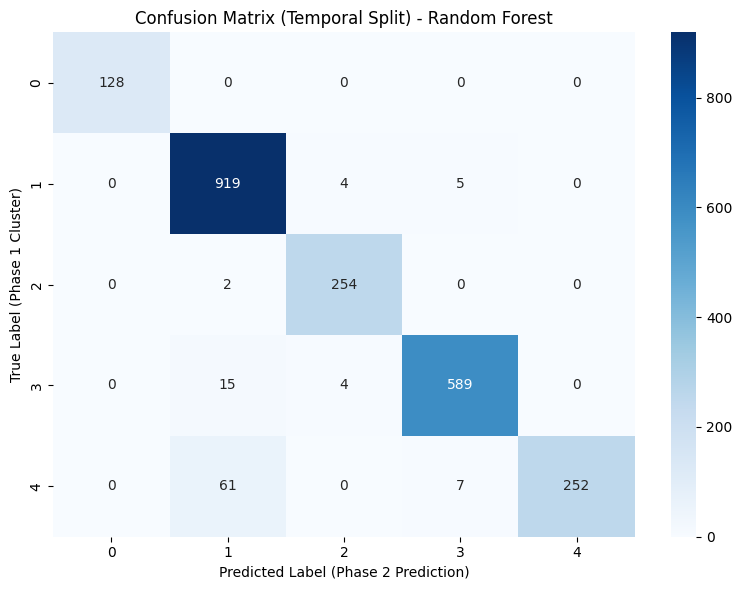

In [10]:
#  Feature Importance (Random Forest - Temporal)
importances = rf_model_temp.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(10, 8))
plt.title("Feature Importance (Drivers of Cultural Clusters) - Random Forest")
plt.barh(range(top_n), importances[indices[:top_n]], align="center", color='#2c3e50')
plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]])
plt.xlabel("Importance Score (Gini Importance)")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig("phase2_feature_importance.png")
plt.show()

#  Confusion Matrix (Random Forest - Temporal) 
# best model's confusion matrix
y_pred_final = rf_model_temp.predict(RobustScaler().fit(df_clean.loc[df_clean['date'].dt.year < 2024, features]).transform(X_test_temp))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_temp, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df_clean['Cluster'].unique()), yticklabels=sorted(df_clean['Cluster'].unique()))
plt.title("Confusion Matrix (Temporal Split) - Random Forest")
plt.ylabel('True Label (Phase 1 Cluster)')
plt.xlabel('Predicted Label (Phase 2 Prediction)')
plt.tight_layout()
plt.savefig("phase2_confusion_matrix.png")
plt.show()